## Data augmentation

Our dataset is very badly equilibrated. The goal is to augmente the data with have in a few less-representated grades.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("..//datasets//avisassurance.csv", encoding="utf-8", sep = ";")
df

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto
...,...,...,...,...,...,...
24100,22 mars 2...,1,hophop-107522,Assurance moto chez la mutuel des motards en F...,Mutuelle des Motards,moto
24101,06 décemb...,1,tzl-81680,Même les demandes les plus simples n'aboutisse...,Allianz,habitation
24102,14 avril ...,1,jmr-72500-110395,"En décembre 2019, j'ai souscrit à un contrat C...",Cegema Assurances,sante
24103,11 juille...,3,cris-77532,Je suis assurer à la gmf depuis plus de 15 ans...,GMF,auto


In [3]:
import gensim.downloader as api

C:\Users\matth\miniconda3\envs\reviews_class\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
# Biggest model
# twitter_25_model = api.load('word2vec-google-news-300')

# Smaller model but might be more efficient (language might be more revelant with tweets than with news)
twitter_25_model = api.load('glove-twitter-25')  
twitter_25_model.most_similar('awesome', topn=5)

[('amazing', 0.9687871932983398),
 ('best', 0.9600659608840942),
 ('fun', 0.9331520795822144),
 ('fantastic', 0.9313924312591553),
 ('perfect', 0.92434161901474)]

In [5]:
twitter_25_model.most_similar('crazy')[0][0]

'mad'

## Plan

##### 1- Traduction from french to english
##### 2- Replacing a few words from the review with most similar one (using gensim most_similar)
##### 3- Traduction from english to french
##### 4- Adding data with the new review to our dataset

Choosing a test review randomly

In [6]:
def random_review_note(df, note:int) -> list():
    row = df[df['note'] == note].sample(n=1)
    avis = str(row['avis'].values)
    note = int(row['note'].values)
    produit = str(row['produit'].values)
    assureur = str(row['assureur'].values)
    return [avis, note, produit, assureur]

In [7]:
test_original, test_note, test_produit, test_assureur = random_review_note(df, 1)
print(test_original)
test_note

["si je pouvais mettre moins, je le ferai, je déteste donner un avis négatif.\r\nMais là... il le faut, pour le bien de l'ensemble des usagers.\r\nQuand on laisse un client plus de 6 mois vous envoyer l'ensemble des informations demandées, que l'on ne lui envoi pas de carte verte définitive pour pouvoir rouler en toute légalité, que malgré des relances à chaque refus on persiste à lui envoyer des messages automatiques et qu'au téléphone on se sait même pas trouver une solution... pour à la fin lui dire qu'il payera une assurance qu'il n'a jamais eue...\r\nj'estime que même le faible prix n'est pas justifié et que c'est très cher pour payer de l'incompétence ! "]


1

In [8]:
test_original = test_original.replace('\\n', '')
test_original = test_original.replace('\\r', '')
test_original

'["si je pouvais mettre moins, je le ferai, je déteste donner un avis négatif.Mais là... il le faut, pour le bien de l\'ensemble des usagers.Quand on laisse un client plus de 6 mois vous envoyer l\'ensemble des informations demandées, que l\'on ne lui envoi pas de carte verte définitive pour pouvoir rouler en toute légalité, que malgré des relances à chaque refus on persiste à lui envoyer des messages automatiques et qu\'au téléphone on se sait même pas trouver une solution... pour à la fin lui dire qu\'il payera une assurance qu\'il n\'a jamais eue...j\'estime que même le faible prix n\'est pas justifié et que c\'est très cher pour payer de l\'incompétence ! "]'

----------------------------
##### 1- Traduction from french to english

In [25]:
from googletrans import Translator
translator = Translator()

def translation_dest_src(review: str, source: str = 'fr', destination: str = 'en') -> str:
    return translator.translate(str(review), src = source, dest = destination).text

In [10]:
test_en = translation_dest_src(test_original,
                source = 'fr',
                destination = 'en')
test_en

'["If I could put less, I\'ll do it, I hate give a negative opinion.But there ... it\'s necessary, for the good of all the users.When a client is left more than 6 months send youtogether the requested information, which one does not send him a final green card to be able to ride in legality, that despite removals to each refusal we persist to send him automatic messages and that the phone we do not even knowFinding a solution ... for the end to tell him he will pay an assurance that he has never had ... I feel that even the low price is not justified and that is very expensive forpay incompetence! "]'

--------------------------------
##### 2- Replacing a few words from the review with most similar one (using gensim most_similar)

The idea is to pick random words in our review and replace them with similar others. We will try with a different ratio replacement to see how it reacts.

In [11]:
import nltk
# input text

# tokene into words
tokens = nltk.word_tokenize(test_en[2:-2])

# parts of speech tagging
tagged = nltk.pos_tag(tokens)

pos_tag_to_keep = ['JJ', 'JJR', 'JJS']
for word in tagged:
    if word[1] in pos_tag_to_keep:
        print('This is something interesting : ' + word[0] + ' because ' + word[1])


This is something interesting : less because JJR
This is something interesting : negative because JJ
This is something interesting : necessary because JJ
This is something interesting : good because JJ
This is something interesting : more because JJR
This is something interesting : final because JJ
This is something interesting : green because JJ
This is something interesting : able because JJ
This is something interesting : automatic because JJ
This is something interesting : low because JJ
This is something interesting : justified because JJ
This is something interesting : expensive because JJ


In [12]:
from random import choice
import nltk

def get_most_similar_word(word: str) -> str:
    # Trying to get the most similar word
    try:
        return twitter_25_model.most_similar(word.lower())[0][0]
    # If not returning the original word
    except:
        # print("Couldn't find the most similar word.")
        return word

def word_replacement(review_eng: str) -> str:
    # tokene into words
    tokens = nltk.word_tokenize(review_eng[2:-2])
    # parts of speech tagging
    tagged = nltk.pos_tag(tokens)

    # Counting the number of words
    nb_words = len(tagged)

    # Creating a list with the placement of changed words, so we don't change twice the same word (could result as getting back to original)
    word_placement_changed = list()

    # Replacing the original word with the most similar one if it's an adverb or an adjective
    pos_tag_to_keep = ['JJ', 'JJR', 'JJS']

    review_eng_replaced = list()
    for word in tagged:
        # If the word is an adverb or an adjective we replace it we a similar one
        if word[1] in pos_tag_to_keep:
            review_eng_replaced.append(get_most_similar_word(word[0]))
        else: #Else we keep the same
            review_eng_replaced.append(word[0])

    return (' '.join(review_eng_replaced))

In [13]:
test_replaced = word_replacement(test_en)
# test_replaced = test_replaced.replace('_', ' ')
test_replaced

"If I could put more , I 'll do it , I hate give a lack opinion.But there ... it 's easier , for the too of all the users.When a client is left enough than 6 months send youtogether the requested information , which one does not send him a champions blue card to be might to ride in legality , that despite removals to each refusal we persist to send him rear messages and that the phone we do not even knowFinding a solution ... for the end to tell him he will pay an assurance that he has never had ... I feel that even the drop price is not practiced and that is very cheap forpay incompetence !"

In [14]:
test_en

'["If I could put less, I\'ll do it, I hate give a negative opinion.But there ... it\'s necessary, for the good of all the users.When a client is left more than 6 months send youtogether the requested information, which one does not send him a final green card to be able to ride in legality, that despite removals to each refusal we persist to send him automatic messages and that the phone we do not even knowFinding a solution ... for the end to tell him he will pay an assurance that he has never had ... I feel that even the low price is not justified and that is very expensive forpay incompetence! "]'

--------------------------------
##### 3- Traduction from english to french

In [15]:
test_replaced = translation_dest_src(test_replaced, source= 'en', destination= 'fr')
test_replaced

"Si je pouvais mettre plus, je le ferai, je déteste donner un manque d'opinion.mais là ... c'est plus facile, pour aussi tous les utilisateurs. Quand un client reste suffisamment de 6 mois envoyer votre demandeInformations, que l'on ne lui envoie pas une carte bleue championne pour pouvoir monter dans la légalité, malgré les déménagements à chaque refus que nous persistons à lui envoyer des messages arrière et que le téléphone que nous ne connaissons même pas une solution ... pour la finPour lui dire, il paiera une assurance qu'il n'a jamais eu ... Je sens que même le prix de la chute n'est pas pratiqué et c'est très bon marché pour incompétence de Forpay!"

In [16]:
test_original

'["si je pouvais mettre moins, je le ferai, je déteste donner un avis négatif.Mais là... il le faut, pour le bien de l\'ensemble des usagers.Quand on laisse un client plus de 6 mois vous envoyer l\'ensemble des informations demandées, que l\'on ne lui envoi pas de carte verte définitive pour pouvoir rouler en toute légalité, que malgré des relances à chaque refus on persiste à lui envoyer des messages automatiques et qu\'au téléphone on se sait même pas trouver une solution... pour à la fin lui dire qu\'il payera une assurance qu\'il n\'a jamais eue...j\'estime que même le faible prix n\'est pas justifié et que c\'est très cher pour payer de l\'incompétence ! "]'

--------------------------------
##### 4- Adding data with the new review to our dataset

In [17]:
def add_row(review_processed: str, note: int, produit: str, assureur: str):
    df.loc[len(df.index)] = ['data augmentation', note, 'data augmentation', review_processed, assureur, produit]

In [18]:
add_row(test_replaced, test_note, test_produit, test_assureur)
df

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto
...,...,...,...,...,...,...
24101,06 décemb...,1,tzl-81680,Même les demandes les plus simples n'aboutisse...,Allianz,habitation
24102,14 avril ...,1,jmr-72500-110395,"En décembre 2019, j'ai souscrit à un contrat C...",Cegema Assurances,sante
24103,11 juille...,3,cris-77532,Je suis assurer à la gmf depuis plus de 15 ans...,GMF,auto
24104,19 janvie...,1,jesse-51459,Bonjour\r\nMon ami vient de se faire voler sa ...,AMV,moto


Now let's augmente our dataset. Goal is to have a more equilibrated distribution of notes.

Reminder on the distribution :

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:title={'center':'Répartition des notes des avis'}, xlabel='note', ylabel='count'>

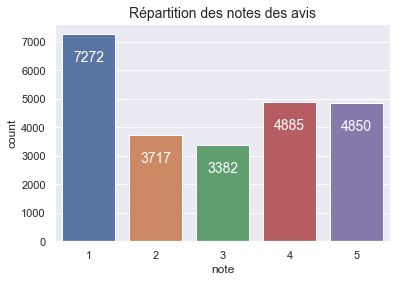

In [20]:
sns.set_theme(style="darkgrid")
countplot_avis = sns.countplot(x = "note", data = df)
countplot_avis.set_title('Répartition des notes des avis', fontsize=14)
# Ajout du count sur la visualisation
for p in countplot_avis.patches:
    countplot_avis.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=14)
countplot_avis

Let's create a function that take in input the note and the number of rows we want to generate.

In [21]:
def rows_generation(note: int, nb: int):
    i = 0
    while i < nb:
        # Getting a random row with a given note
        review, note_, produit, assureur = random_review_note(df, note)

        # Translating from french to english
        review_eng = translation_dest_src(review,
                    source = 'fr',
                    destination = 'en')

        # Replacing words
        review_eng_processed = word_replacement(review_eng)
        
        # Translating from english to french
        review_fr_processed = translation_dest_src(review_eng_processed,
                    source = 'en',
                    destination = 'fr')

        # Adding the new row in our dataframe
        add_row(review_fr_processed, note_, produit[2:-2], assureur[2:-2])

        i += 1

In [22]:
rows_generation(4, 1)
df

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto
...,...,...,...,...,...,...
24102,14 avril ...,1,jmr-72500-110395,"En décembre 2019, j'ai souscrit à un contrat C...",Cegema Assurances,sante
24103,11 juille...,3,cris-77532,Je suis assurer à la gmf depuis plus de 15 ans...,GMF,auto
24104,19 janvie...,1,jesse-51459,Bonjour\r\nMon ami vient de se faire voler sa ...,AMV,moto
24105,data augmentation,1,data augmentation,"Si je pouvais mettre plus, je le ferai, je dét...","[""L'olivier Assurance""]",['auto']


Let's try to have at least 4500 of each grades.

In [ ]:
# For grades of 2
nb = 4500 - len(df[df['note'] == 2])
rows_generation(note = 2, nb = nb)

<AxesSubplot:title={'center':'Répartition des notes des avis'}, xlabel='note', ylabel='count'>

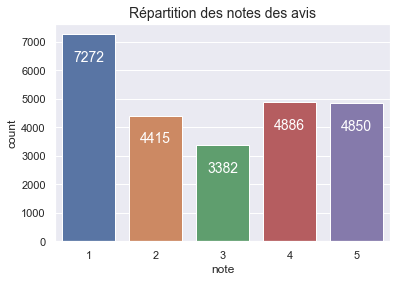

In [24]:
sns.set_theme(style="darkgrid")
countplot_avis = sns.countplot(x = "note", data = df)
countplot_avis.set_title('Répartition des notes des avis', fontsize=14)
# Ajout du count sur la visualisation
for p in countplot_avis.patches:
    countplot_avis.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=14)
countplot_avis

In [26]:
# For grades of 3
nb = 4500 - len(df[df['note'] == 3])
rows_generation(note = 3, nb = nb)

<AxesSubplot:title={'center':'Répartition des notes des avis'}, xlabel='note', ylabel='count'>

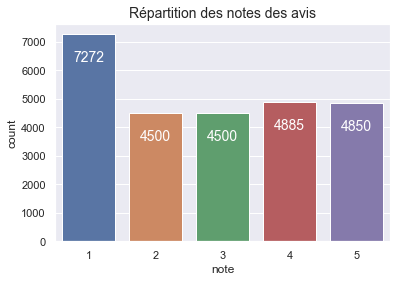

In [ ]:
sns.set_theme(style="darkgrid")
countplot_avis = sns.countplot(x = "note", data = df)
countplot_avis.set_title('Répartition des notes des avis', fontsize=14)
# Ajout du count sur la visualisation
for p in countplot_avis.patches:
    countplot_avis.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=14)
countplot_avis

Exporting our augmented dataframe

In [ ]:
df.to_pickle('df_augmented.pkl')